# Importando as bibliotecas

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os
import sys
sys.path.insert(0, os.path.abspath('../Util'))
from dados import ProcessarDados
#!python -m pip install --user scikit-mlm

from skmlm import NN_MLM, MLMC

#from skmlm import FCM_MLM as NN_MLM

# Dataset

In [3]:
procData = ProcessarDados("../dataset/norm_bin_10_FEATURES_M17_CM6b_TH199.csv")

# Funções

In [4]:
# funcção que treina e testa o modelo armazenando as métricas
# retorna um dicionário cotendo os valores das métricas de cada rodada
def treinamento_teste(epocas = 10, k_folds = 5, exibir_matriz_confusao=False, exibir_metricas=False):
    
    #array para armazenar as das métricas de cada rodada
    resultados_accuracy = []
    resultados_precision = []
    resultados_recall = []
    resultados_specificity = [] # taxa de verdadeiros negativos ou especificidade
    resultados_f2 = []
    resultados_parametros = []
    
    #dicionário das métricas
    resultados_gerais = {}

    for i in range(epocas):
        # divisão os dados 
        seed = i
        X_train, X_test, y_train, y_test = procData.holdout(0.2, seed)
        #print(Counter(y_test))

        # realizando o grid search para encontrar a melhor combinação de parametros, 
        # considerando a acurácia (taxa de acerto)
        # aqui o método GridSearchCV é configurado para subdividir os dados de treino em k_folds
        clf = NN_MLM(random_state=seed)
        grid_mlm = GridSearchCV(clf, param_grid, cv=k_folds, scoring='accuracy', verbose=0)
        grid_mlm.fit(X_train, y_train)

        #CV_RESULTS
        grid_mean_scores = grid_mlm.cv_results_['mean_test_score']
        
        ##PLOT
        plt.plot(rp_number, grid_mean_scores)
        plt.xlabel('Pontos de Referência')
        plt.ylabel('Acurácia')
        
        # Treinando do modelo com os melhores parametros encontrados
        rp_number_best = grid_mlm.best_estimator_.rp_number

        MLM = NN_MLM(rp_number = rp_number_best, random_state=seed)
        MLM.fit(X_train, y_train)

        #testando o modelo
        y_pred = MLM.predict(X_test)
        cm  = confusion_matrix(y_test, y_pred)
        if exibir_matriz_confusao:
            print(cm)

        # calculado as metricas
        accuracy = metrics.accuracy_score(y_test, y_pred)
        precision = metrics.precision_score(y_test, y_pred)
        recall = metrics.recall_score(y_test, y_pred)
        # f2-score
        # Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)
        beta = 0.5
        f2_score = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)
        tn, fp, fn, tp = cm.ravel()
        specificity = tn / (tn+fp)

        # armazenando as métricas
        resultados_accuracy.append(accuracy)
        resultados_precision.append(precision)
        resultados_recall.append(recall)
        resultados_specificity.append(specificity)
        resultados_f2.append(f2_score)

        best_parametros = {"rp_number": rp_number_best};
        resultados_parametros.append(best_parametros)


        if exibir_metricas:
            print("Rodada: #",i)
            print(best_parametros)
            print("Accuracy:",accuracy)
            print("Precision:",precision)
            print("Recall:",recall)
            print("Specificity:",specificity)
            print("f2-Score:",f2_score)
            print("\n")

            
    resultados_gerais['accuracy'] = resultados_accuracy
    resultados_gerais['precision'] = resultados_precision
    resultados_gerais['recall'] = resultados_recall
    resultados_gerais['specificity'] = resultados_specificity
    resultados_gerais['f2'] = resultados_f2
    resultados_gerais['params'] = resultados_parametros
    
    return resultados_gerais

In [5]:
def tabelaMetricas(nome_modelo, dict_metricas, rodadas=False, salvarResultados=True):
        
    print ("============================================== "+nome_modelo+" =================================================")
    print ("=================================== TABELA DE MÉTRICAS DO MODELO ===================================")
    
    if(rodadas==False):
        print ("\t Accuracy \t|\t Precision \t|\t Recall \t|\tSpecificity \t|\t fb-Score")
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['accuracy'], axis=0), np.std(dict_metricas['accuracy'], axis=0)),end=' ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['precision'], axis=0), np.std(dict_metricas['precision'], axis=0)),end='  ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['recall'], axis=0), np.std(dict_metricas['recall'], axis=0)),end=' ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['specificity'], axis=0), np.std(dict_metricas['specificity'], axis=0)),end='   ')
        print ("      %.4f +- %.4f" % (np.mean(dict_metricas['f2'], axis=0), np.std(dict_metricas['f2'], axis=0)))
        print ("====================================================================================================")
        
    if(salvarResultados):
        # save to npy file
        np.save('../resultados/resultados_'+nome_modelo+'.npy', dict_metricas)

# Definindo os parâmetros

In [8]:
# pontos de referencia
rp_number = np.arange(0.7,0.8,0.1)
param_grid = {'rp_number': rp_number}

epocas = 1
k_folds = 5
exibir_matriz_confusao = True
exibir_metricas = True
salvarResultados = True
rodadas=False

# Treinando e obtendo as métricas do modelo

[[28  0]
 [92  0]]
Rodada: # 0
{'rp_number': 336}
Accuracy: 0.23333333333333334
Precision: 0.0
Recall: 0.0
Specificity: 1.0
f2-Score: nan


============================================== MLM =================================================
=================================== TABELA DE MÉTRICAS DO MODELO ===================================
	 Accuracy 	|	 Precision 	|	 Recall 	|	Specificity 	|	 fb-Score
      0.2333 +- 0.0000       0.0000 +- 0.0000        0.0000 +- 0.0000       1.0000 +- 0.0000         nan +- nan


/Users/edilainesantiago/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/edilainesantiago/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


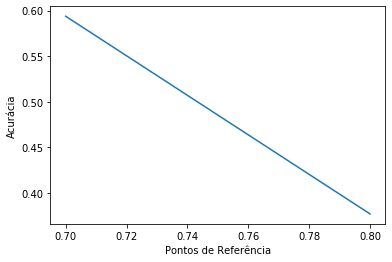

In [9]:
# treinando o modelo
dict_metricas = treinamento_teste(epocas, k_folds, exibir_matriz_confusao, exibir_metricas)
tabelaMetricas('MLM',dict_metricas, rodadas, salvarResultados)